# Part 0.5: The Goodbooks Dataset

For the Alternating Least Squares and Stochastic Gradient Descent matrix factorization recommendation systems, the notebooks will be using [the Goodbooks dataset](https://www.kaggle.com/zygmunt/goodbooks-10k#ratings.csv) hosted on Kaggle. This notebook introduces the dataset, performs some initial analysis, and creates a train / test datset.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import PIL
import random
import sklearn

random.seed(42)
np.random.seed(42)

The provided dataset involves user ratings for different books. Although the dataset provides lots of metadata about each of the books (such as tags, genre, etc), the following notebooks will be using none of these features. Instead, the notebooks use only a single file, the user ratings. This ratings file consists of three columns:

* book_id: a unique identifier for each book being reviewed. There are 10,000 different books in the dataset. 
* user_id: a unique identifier for each user that reviews a book. There are ~54k unique users in the dataset. 
* rating: an integer between 1 and 5 which records the rating the user gave each of the books. A rating of 1 indicates that the user strongly disliked the book, while a rating of 5 indicates that the user strongly liked the book.

In [4]:
ratings = pd.read_csv('datasets/ml-100k/u.data', sep='\t', header=None)
ratings.columns=['user_id', 'book_id', 'rating', 'timestamp']
del ratings['timestamp']
print('The shape of user_ratings is {0}'.format(ratings.shape))
ratings.head()

The shape of user_ratings is (100000, 3)


,user_id,book_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Although there are approximately 1 million records, the data shows a long-tailed distribution. Many users only review a few books, and many books are only reviewed by a few users. There are also a few super-reviewers that have reviewed a ton of books.

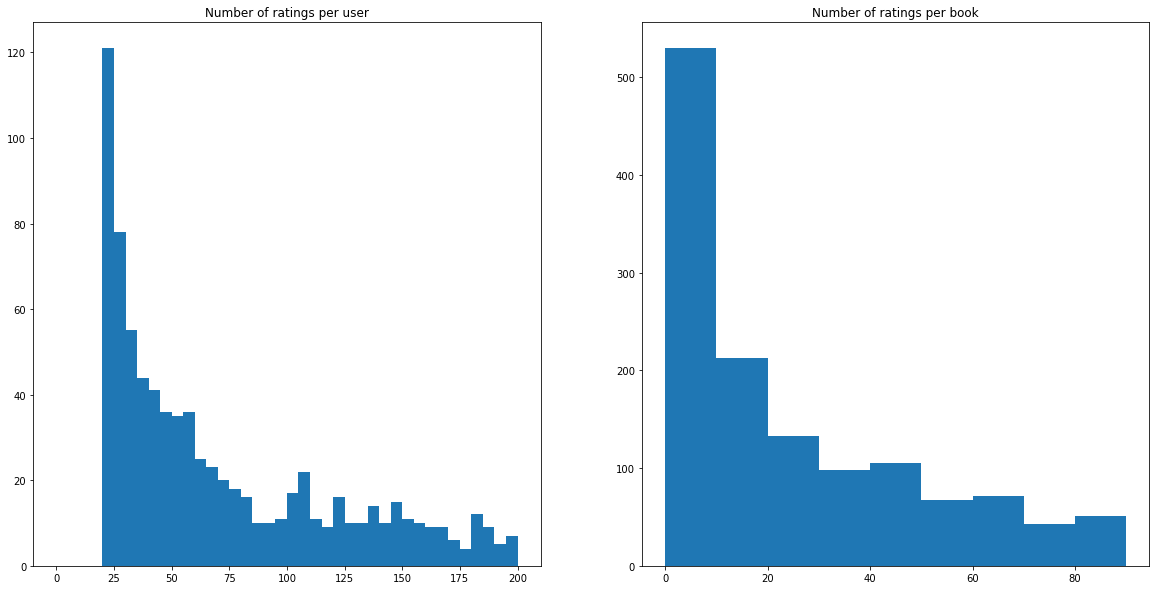

In [5]:
ratings_per_user = ratings.groupby('user_id').size().reset_index()
ratings_per_user.columns = ['user_id', 'number_of_ratings']

ratings_per_book = ratings.groupby('book_id').size().reset_index()
ratings_per_book.columns = ['book_id', 'number_of_ratings']

fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax_left.hist(ratings_per_user['number_of_ratings'], bins=list(range(0, 205, 5)))
ax_left.set_title('Number of ratings per user')
ax_right.hist(ratings_per_book['number_of_ratings'], bins=list(range(0, 100, 10)))
ax_right.set_title('Number of ratings per book')

plt.show()

We can see that most reviewers have given few ratings, but most books are quite well reviewed. Since we are building a recommendation system, it is unlikely that the system will be able to recommend for users that have very few ratings. Also, it is unlikely that the system will be able to recommend for books that have very few reviews. 

To clean up these outliers, we will filter out users that have given fewer thatn four ratings, and books that have been reviewed by fewer than five users. These numbers were chosen somewhat arbitrarily, with a goal of filtering out users that have given few reviews while still maintaining the bulk of the users in the dataset. Try changing these thresholds and seeing what effect it has on the models in future notebooks!

In [7]:
valid_users = ratings_per_user[ratings_per_user['number_of_ratings'] >= 20]['user_id']
valid_books = ratings_per_book[ratings_per_book['number_of_ratings'] >= 5]['book_id']
filtered_ratings = ratings[ratings['user_id'].isin(valid_users) & ratings['book_id'].isin(valid_books)].copy()

print('After filtering, there are {0} / {1} ({2:.2f}%) ratings left in the dataset'.format(filtered_ratings.shape[0], ratings.shape[0], filtered_ratings.shape[0] * 100.0 / ratings.shape[0]))
print('After filtering, there are {0} / {1} ({2:.2f}%) users left in the dataset.'.format(len(valid_users), ratings_per_user.shape[0], len(valid_users) * 100.0 / ratings_per_user.shape[0]))
print('After filtering, there are {0} / {1} ({2:.2f}%) books left in the dataset.'.format(len(valid_books), ratings_per_book.shape[0], len(valid_books) * 100.0 / ratings_per_book.shape[0]))
print('Sparsity is {0}%'.format(filtered_ratings.shape[0] * 100.0 / (len(valid_users) * len(valid_books))))

After filtering, there are 99287 / 100000 (99.29%) ratings left in the dataset
After filtering, there are 943 / 943 (100.00%) users left in the dataset.
After filtering, there are 1349 / 1682 (80.20%) books left in the dataset.
Sparsity is 7.804925214624242%


For convenience in the later notebooks, we will remap the user_ids and book_ids so they are continuous

In [8]:
distinct_valid_users = sorted(list(filtered_ratings['user_id'].unique()))
distinct_valid_books = sorted(list(filtered_ratings['book_id'].unique()))

user_mapping = {}
for i in range(0, len(distinct_valid_users), 1):
    user_mapping[distinct_valid_users[i]] = i

book_mapping = {}
for i in range(0, len(distinct_valid_books), 1):
    book_mapping[distinct_valid_books[i]] = i
    
filtered_ratings['user_id'] = filtered_ratings.apply(lambda r: user_mapping[r['user_id']], axis=1)
filtered_ratings['book_id'] = filtered_ratings.apply(lambda r: book_mapping[r['book_id']], axis=1)

In [9]:
print(min(filtered_ratings['book_id']))

0


To create the train / test split, two reviews from each user are sampled at random and placed in the test set. The remaining reviews are placed in the train set. This process will avoid the issue of having all of a user's reviews being placed inside of the test set.

In [10]:
filtered_ratings = sklearn.utils.shuffle(filtered_ratings)

test_user_id_counts = {}
num_ratings_to_take = 2

def is_train_set(row):
    user_id = row['user_id']
    book_id = row['book_id']
    if user_id not in test_user_id_counts:
        test_user_id_counts[user_id] = 1
        return 0
    else:
        if test_user_id_counts[user_id] < num_ratings_to_take:
            test_user_id_counts[user_id] += 1
            return 0
        else:
            return 1
        
filtered_ratings['is_train_set'] = filtered_ratings.apply(lambda r: is_train_set(r), axis=1)

With this rule, the train/test split is approximately 92% / 8%. This should be sufficient for the future notebooks.

In [16]:
print(max(train_set['book_id']))

1348


In [11]:
test_set = filtered_ratings[filtered_ratings['is_train_set'] == 0]
train_set = filtered_ratings[filtered_ratings['is_train_set'] == 1]

del train_set['is_train_set']
del test_set['is_train_set']

print('The test set contains {0} / {1} ({2:.2f}%) of the examples.'.format(test_set.shape[0], filtered_ratings.shape[0], test_set.shape[0] * 100.0 / filtered_ratings.shape[0]))
print('The train set contains {0} / {1} ({2:.2f}%) of the examples.'.format(train_set.shape[0], filtered_ratings.shape[0], train_set.shape[0] * 100.0 / filtered_ratings.shape[0]))

train_set.to_csv('datasets/goodbooks/train.csv', index=False)
test_set.to_csv('datasets/goodbooks/test.csv', index=False)

The test set contains 1886 / 99287 (1.90%) of the examples.
The train set contains 97401 / 99287 (98.10%) of the examples.
